In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
# 1. Load Data
df = pd.read_csv("5000_balanced_final_custom.csv")

In [28]:
# 2. Encode label (multi-class)
le = LabelEncoder()
y = le.fit_transform(df['label'])
X_text = df['cleaned_content']

In [29]:
# 3. TF-IDF vectorization (max_features=5000)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X_text)

In [30]:
count = df['label'].value_counts()
print("Jumlah data per label:")
for label, count in count.items():
    print(f"{label}: {count}")

Jumlah data per label:
informationquality: 2104
reliability: 1087
responsiveness: 832
easeofuse: 494
webdesign: 279
privacy: 204


In [31]:
# 4. K-Fold + SVM Linear
kf = KFold(n_splits=5, shuffle=True, random_state=42)


=== Fold 1 ===
Accuracy: 0.982
F1-score (macro): 0.9803
                    precision    recall  f1-score   support

         easeofuse       1.00      0.93      0.97       105
informationquality       0.97      1.00      0.98       404
           privacy       1.00      0.94      0.97        31
       reliability       1.00      0.98      0.99       214
    responsiveness       0.97      0.99      0.98       179
         webdesign       1.00      1.00      1.00        67

          accuracy                           0.98      1000
         macro avg       0.99      0.97      0.98      1000
      weighted avg       0.98      0.98      0.98      1000


=== Fold 2 ===
Accuracy: 0.986
F1-score (macro): 0.9821
                    precision    recall  f1-score   support

         easeofuse       0.97      0.98      0.98       101
informationquality       0.99      0.98      0.98       427
           privacy       1.00      0.90      0.95        40
       reliability       0.99      1.00   

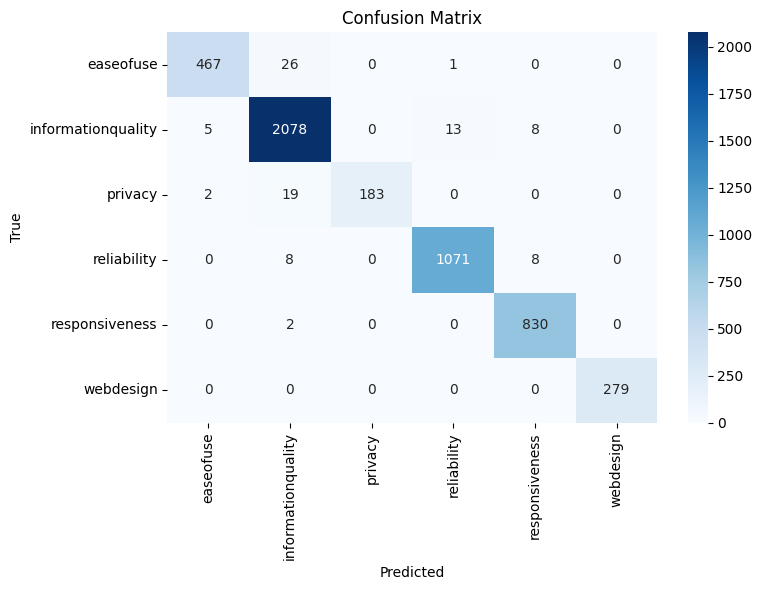

In [32]:
f1_scores = []
accuracies = []

# Tambahkan list untuk menyimpan semua y_test dan y_pred dari semua fold
all_y_true = []
all_y_pred = []

for i, (train_idx, test_idx) in enumerate(kf.split(X_tfidf, y), 1):
    X_train, X_test = X_tfidf[train_idx], X_tfidf[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train SVM with linear kernel
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\n=== Fold {i} ===")
    print("Accuracy:", round(acc, 4))
    print("F1-score (macro):", round(f1, 4))
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    accuracies.append(acc)
    f1_scores.append(f1)

    # ⬇ Simpan hasil prediksi dari fold ini
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# 5. Confusion Matrix GLOBAL (dari semua fold)
cm_global = confusion_matrix(all_y_true, all_y_pred)

# Plot Confusion Matrix Global
plt.figure(figsize=(8, 6))
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [33]:
# 5. Summary of all folds
print("\n=== RATA-RATA FOLD ===")
for i in range(len(accuracies)):
    print(f"Fold {i+1} - Accuracy: {round(accuracies[i], 4)}, F1-score: {round(f1_scores[i], 4)}")
print("Average Accuracy:", round(np.mean(accuracies), 4))
print("Average F1-score (macro):", round(np.mean(f1_scores), 4))


=== RATA-RATA FOLD ===
Fold 1 - Accuracy: 0.982, F1-score: 0.9803
Fold 2 - Accuracy: 0.986, F1-score: 0.9821
Fold 3 - Accuracy: 0.976, F1-score: 0.97
Fold 4 - Accuracy: 0.976, F1-score: 0.9745
Fold 5 - Accuracy: 0.988, F1-score: 0.9831
Average Accuracy: 0.9816
Average F1-score (macro): 0.978
